In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path

In [3]:
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
tpdata = pd.read_table("data/%40CL_Daily.txt",delimiter=',',header=0,parse_dates=[['Date','Time']],usecols=['Date','Time','Close'])
print(tpdata['Close'][:10])

0    104.22
1    104.67
2    104.02
3    104.12
4    104.53
5    104.30
6    105.23
7    103.96
8    103.71
9    102.83
Name: Close, dtype: float64


In [98]:
from scipy.signal import savgol_filter as smooth
# this function returns the local maxima and the minima
# ltp is a list of [date, price]
# n is the width of window to examine max and min
# n has to be an odd number greater than 3
# return: max and min [(date,price),(date,price),(),(),...]
def max_min(ltp,n):
    ltp_sm = smooth(ltp['Close'],n,3)
    max_points = []
    min_points = []
    ltp_dif = np.zeros(ltp_sm.shape[0]-1)
    ltp_dif = ltp_sm[1:]-ltp_sm[:-1]
    center = int((n-1)/2)
    for i in range(ltp_dif.shape[0]-n+2):
        window = ltp_dif[i:i+n-1]
        front = window[:center]
        back = window[center:]
        s_first = np.sum(front<0)
        s_back = np.sum(back>0)
        r_first = np.sum(front>0)
        r_back = np.sum(back<0)
        if(r_first == center and r_back == center):
            max_points.append((ltp['Date_Time'].iloc[i+center],ltp['Close'].iloc[i+center]))
            # print(ltp[i+center])
        if(s_first== center and s_back== center):
            min_points.append((ltp['Date_Time'].iloc[i+center],ltp['Close'].iloc[i+center]))
            # print(ltp[i+center])
    return max_points,min_points
scanning_window=5

In [101]:
# sort the max and min according to the price.
# this facilitate clustering in next step
maxima,minima = max_min(tpdata[500:1000],scanning_window)
max_points = sorted(maxima, key=lambda x: x[1])
min_points = sorted(minima, key=lambda x: x[1])
# max_pair = maxima[maxima[:,1].argsort()]
# min_pair = minima[minima[:,1].argsort()]
print(len(max_points))
print(len(min_points))

38
40


In [6]:
# this function take in sorted date-price tupel and find the cluster
# according to price and threshold given
# it return a group in shape [[(date,price),(date,price),()...],[],...]
def cluster(pairs, threshold):
    groups = []
    current = []
    vl = 0
    for pair in pairs:
        # print(pair)
        if not current:
            current.append(pair)
            vl = pair[1]
            #print('1')
        elif pair[1]-vl<threshold:
            current.append(pair)
            #print('2')
        else:
            if len(current)>1:
                groups.append(sorted(current))
            vl = pair[1]
            current = [pair]
            #print('3')
    return groups
cluster_threshold = 0.8

In [18]:
# max_points clustted together is called max_group
max_group = cluster(max_points,cluster_threshold)
min_group = cluster(min_points,cluster_threshold)
print(len(min_group))
print(len(max_group))

15

12


transfer back to numpy array for easiness to index
they are tuple in prior steps because np array only support
one dtype. String and float can not co-exist. For sorting and
clustering purposes, they have to be converted to tuple

In [16]:
# assumes each group in group list is sorted already
# data is the total data [date,price]. Date should be in datetime64[D]
# the output is of shape [[[date],[price]],[[date],[price]],...]
def into_arr(group_list,data,support=True):
    groups=[]
    for group in group_list:
        # extract date, price
        date = np.asarray(group)[:,0]
        price = np.asarray(group)[:,1]
        price = price.astype(np.float)
        # form line, calculate when line start and stop
        average_price = np.average(price)
        mask_after_first = data[:,0] > date[0]
        if support:
            break_through = data[:,1] < np.min(price)
        else:
            break_through = data[:,1] > np.max(price)
        break_through = np.bitwise_and(break_through,mask_after_first)
                    
        # fix the intersection and eliminate the fake lines
        slicing_date = date
        print("the date series is")
        print(slicing_date)
        break_times = np.array([])
        if np.sum(np.argwhere(break_through))>0:
            break_times = data[:,0][np.argwhere(break_through)]
        print("the break time")
        print(break_times)
        for break_time in break_times:
            num_before_break = np.sum(slicing_date<break_time)
            # two or more times before break through, form a line
            if num_before_break > 1:
                # the last point before the break point
                last_point_before_break = np.argwhere(slicing_date < break_time)[-1][0]
                print(last_point_before_break)
                print(slicing_date)
                # last_date = slicing_date[last_point_before_break]
                date_range = pd.date_range(slicing_date[0],break_time[0])
                df = pd.DataFrame({'support':[average_price for i in range(date_range.shape[0])]},index=date_range)
                if(not support):
                    df.rename(columns={'support':'resistance'}, inplace=True)
                groups.append(df)
#                 if last_point_before_break + 2 > slicing_date.shape[0]:
#                     slicing_date = 
#                     break
                if slicing_date.shape[0] > last_point_before_break+1:
                    slicing_date = slicing_date[last_point_before_break+1:]
                else:
                    slicing_date = np.array([])
            # only one single point before break through, discard
            elif slicing_date.shape[0] > 1:
                if num_before_break == 1:
                    slicing_date = slicing_date[1:]
            # no points before break through
            else:
                break               
        # if break_time runs out but slicing_date stills exist,
        # breaks in the middle, and exist until the last points
        # or no break points at all
        if slicing_date.shape[0]>1:
            last_date = data[:,0][-1]
            date_range = pd.date_range(slicing_date[0],last_date)
            df = pd.DataFrame({'support':[average_price for i in range(date_range.shape[0])]},index=date_range)
            if(not support):
                df.rename(columns={'support':'resistance'}, inplace=True)
            groups.append(df)            
#         print("the current group is ")
#         print(group)
#         print(last_date, end=" ")
#         if(len(np.argwhere(break_through))>0):
#             print(data[:,1][np.argwhere(break_through)[0][0]])
#         else:
#             print(data[:,1][-1])
#         print('average price', end=' ')
#         print(average_price)

        
    return groups

In [17]:
print(len(min_group))
print(len(max_group))

15
12


In [11]:
support = into_arr(min_group,tpdata[:500].as_matrix(),True)
print("###################################################################")
resistance = into_arr(max_group,tpdata[:500].as_matrix(),False)

the date series is
[Timestamp('2001-11-19 17:00:00') Timestamp('2002-01-22 17:00:00')
 Timestamp('2002-01-30 17:00:00')]
the break time
[]
the date series is
[Timestamp('2001-11-26 17:00:00') Timestamp('2001-12-12 17:00:00')]
the break time
[[Timestamp('2001-12-11 17:00:00')]
 [Timestamp('2001-12-13 17:00:00')]
 [Timestamp('2002-01-16 17:00:00')]
 [Timestamp('2002-01-18 17:00:00')]
 [Timestamp('2002-01-22 17:00:00')]
 [Timestamp('2002-01-23 17:00:00')]
 [Timestamp('2002-01-30 17:00:00')]
 [Timestamp('2002-01-31 17:00:00')]]
the date series is
[Timestamp('2001-12-25 17:00:00') Timestamp('2002-01-01 17:00:00')
 Timestamp('2002-02-26 17:00:00')]
the break time
[[Timestamp('2002-01-14 17:00:00')]
 [Timestamp('2002-01-15 17:00:00')]
 [Timestamp('2002-01-16 17:00:00')]
 [Timestamp('2002-01-17 17:00:00')]
 [Timestamp('2002-01-18 17:00:00')]
 [Timestamp('2002-01-22 17:00:00')]
 [Timestamp('2002-01-23 17:00:00')]
 [Timestamp('2002-01-24 17:00:00')]
 [Timestamp('2002-01-25 17:00:00')]
 [Timestam

In [15]:
print(len(support))
print(len(resistance))

7
8


In [13]:
def plot_sr(data,support,resist):
    color=['b']
    for i in support:
        data = data.merge(i,how='left',left_on='Date_Time',right_index=True)
        color.append('g')
    for i in resist:
        data = data.merge(i,how='left',left_on='Date_Time',right_index=True)
        color.append('r')
    data.plot(x='Date_Time',legend=False,color = color)
    #print(data[:5])
    plt.show()

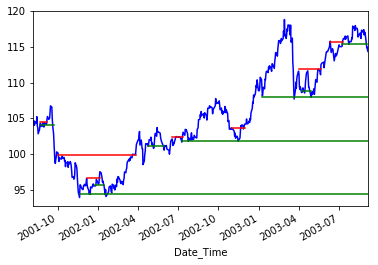

In [14]:
plot_sr(tpdata[:500],support,resistance)